In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from random import random
from math import exp
import plotly.express as px

In [48]:
def loadData():
    data = load_iris()
    inputs = data['data']
    outputs = data['target']
    outputsName = data['target_names']
    featureNames = list(data['feature_names'])
    feature1 = [feat[featureNames.index('sepal length (cm)')] for feat in inputs]
    feature2 = [feat[featureNames.index('sepal width (cm)')] for feat in inputs]
    feature3 = [feat[featureNames.index('petal length (cm)')] for feat in inputs]
    feature4 = [feat[featureNames.index('petal width (cm)')] for feat in inputs]
    inputs = [[feat[featureNames.index('sepal length (cm)')],
               feat[featureNames.index('sepal width (cm)')],
               feat[featureNames.index('petal length (cm)')],
               feat[featureNames.index('petal width (cm)')]] for feat in inputs]
    return inputs, outputs, outputsName, feature1, feature2, feature3, feature4, featureNames

In [49]:
def plotData(inputs, outputs, outputNames, featureNames, title=None):
    x = [i[0] for i in inputs]
    y = [i[1] for i in inputs]
    z = [i[2] for i in inputs]
    v = [i[3] for i in inputs]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=outputs, cmap='viridis', label='Type')
    ax.set_xlabel(featureNames[0])
    ax.set_ylabel(featureNames[1])
    ax.set_zlabel(featureNames[2])
    ax.set_title(title)
    ax.legend()
    plt.show()


def plotHistogram(feature, variableName):
    plt.hist(feature, 10)
    plt.title('Histogram of ' + variableName)
    plt.show()


def plotPredictions(inputs, realOutputs, computedOutputs, labelNames, featureNames, title=None):
    labels = list(set(realOutputs))
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        y = [inputs[i][1] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        plt.scatter(x, y, label=labelNames[crtLabel] + ' (correct)')
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        y = [inputs[i][1] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        plt.scatter(x, y, label=labelNames[crtLabel] + ' (incorrect)')
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.title(title)
    plt.legend()
    plt.show()

In [50]:
def sigmoid(x):
    return 1 / (1 + exp(-x))
    
def mse(computed, real):
    error = 0.0
    for y1, y2 in zip(computed, real):
        error += (y1 - y2) ** 2
    error /= len(real)
    return error

In [51]:
class MyLogisticRegression:
    def __init__(self):
        self.intercept_ = []
        self.coef_ = []

    # Batch gradient descent for training the model
    def fit_batch(self, x, y, learningRate=0.0001, noEpochs=1000):
        self.coef_ = []
        self.intercept_ = []
        labels = list(set(y))

        # initialize random coefficients for each label
        for label in labels:
            coefficient = [random() for _ in range(len(x[0]) + 1)]

            for _ in range(noEpochs):
                errors = [0] * len(coefficient)

                 # compute errors for each sample
                for input, output in zip(x, y):
                    yComputed = sigmoid(self.eval(input, coefficient))
                    error = yComputed - 1 if output == label else yComputed
                    for i, xi in enumerate([1] + list(input)):
                        errors[i] += error * xi
                # update coefficients
                for i in range(len(coefficient)):
                    coefficient[i] = coefficient[i] - learningRate * errors[i]
                    
            self.intercept_.append(coefficient[0])
            self.coef_.append(coefficient[1:])


    # Stochastic gradient descent for training the model
    def fit(self, x, y, learningRate=0.001, noEpochs=1000):
        self.intercept_ = []
        self.coef_ = []
        labels = list(set(y))
        
        for label in labels:
            coefficient = [random() for _ in range(len(x[0]) + 1)]
            
            for _ in range(noEpochs):
                for input, output in zip(x, y):
                    yComputed = sigmoid(self.eval(input, coefficient))
                    error = yComputed - 1 if output == label else yComputed

                    # Update coefficients for each feature
                    for j in range(len(x[0])):
                        coefficient[j + 1] = coefficient[j + 1] - learningRate * error * input[j]
                    coefficient[0] = coefficient[0] - learningRate * error
                    
            self.intercept_.append(coefficient[0])
            self.coef_.append(coefficient[1:])

    def eval(self, xi, coefficient):
        yi = coefficient[0]
        for j in range(len(xi)):
            yi += coefficient[j + 1] * xi[j]
        return yi

    # Predict label for one sample
    def predictOneSample(self, sampleFeatures):
        predictions = []
        
        # Compute predictions for each label
        for intercept, coefficient in zip(self.intercept_, self.coef_):
            computedValue = self.eval(sampleFeatures, [intercept] + coefficient)
            predictions.append(sigmoid(computedValue))

        # Return the label with the maximum predicted probability
        return predictions.index(max(predictions))

    # Predict labels for multiple samples
    def predict(self, inTest):
        computedLabels = [self.predictOneSample(sample) for sample in inTest]
        return computedLabels

In [52]:
# split data into training and testing sets
def splitData(inputs, outputs):
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    testSample = [i for i in indexes if i not in trainSample]
    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    return trainInputs, trainOutputs, testInputs, testOutputs


def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        #encode each sample into a list
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]
        
        scaler.fit(trainData) # fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data

        #decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData) # fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
    return normalisedTrainData, normalisedTestData

In [53]:
def learnModelTool(trainInputs, trainOutputs, testInputs, testOutputs):
    classifier = linear_model.LogisticRegression()
    classifier.fit(trainInputs, trainOutputs)
    
    # Print learned models for each label
    for label in range(len(classifier.intercept_)):
        w = [classifier.intercept_[label]] + list(classifier.coef_[label])
        print(f'classification model (tool) label {label + 1}: y = {w[0]} + {w[1]} * x1 + {w[2]} * x2 + {w[3]} * x3 + {w[4]} * x4')

    # Predict outputs for test inputs
    computedOutputs = classifier.predict(testInputs)

    # Print accuracy score
    accuracy = classifier.score(testInputs, testOutputs)
    print("Accuracy score:", accuracy)

    return computedOutputs

def learnModel(trainInputs, trainOutputs, testInputs, testOutputs, dim_flower):
    classifier = MyLogisticRegression()
    classifier.fit_batch(trainInputs, trainOutputs)

    # Print learned models for each label
    for label in range(len(classifier.intercept_)):
        w = [classifier.intercept_[label]] + list(classifier.coef_[label])
        print(f'classification model label {label + 1}: y = {w[0]} + {w[1]} * feat1 + {w[2]} * feat2 + {w[3]} * feat3 + {w[4]} * feat4')

    # Predict outputs for test inputs
    computedOutputs = classifier.predict(testInputs)

    # flower prediction
    flower = classifier.predict(dim_flower)

    # Calculate accuracy manually
    accuracy = sum(1 for true, pred in zip(testOutputs, computedOutputs) if true == pred) / len(testOutputs)
    print("Accuracy score:", accuracy)

    return computedOutputs, flower

In [54]:
def learnModelTool(trainInputs, trainOutputs, testInputs, testOutputs):
    classifier = linear_model.LogisticRegression()
    classifier.fit(trainInputs, trainOutputs)
    w0, w1, w2, w3, w4 = classifier.intercept_[0], classifier.coef_[0][0], classifier.coef_[0][1], classifier.coef_[0][2], classifier.coef_[0][3]
    print('classification model (tool) label 1: y =', w0, '+', w1, '* x1 +', w2, '* x2 +', w3, '* x3 +', w4, '* x4')
    w0, w1, w2, w3, w4 = classifier.intercept_[1], classifier.coef_[1][0], classifier.coef_[1][1], classifier.coef_[1][2], classifier.coef_[1][3]
    print('classification model (tool) label 2: y =', w0, '+', w1, '* x1 +', w2, '* x2 +', w3, '* x3 +', w4, '* x4')
    w0, w1, w2, w3, w4 = classifier.intercept_[2], classifier.coef_[2][0], classifier.coef_[2][1], classifier.coef_[2][2], classifier.coef_[2][3]
    print('classification model (tool) label 3: y =', w0, '+', w1, '* x1 +', w2, '* x2 +', w3, '* x3 +', w4, '* x4')
    computedOutputs = classifier.predict(testInputs)
    print("Accuracy score:", classifier.score(testInputs, testOutputs))
    return computedOutputs

def learnModel(trainInputs, trainOutputs, testInputs, testOutputs, dim_flower):
    classifier = MyLogisticRegression()
    classifier.fit_batch(trainInputs, trainOutputs)
    w0, w1, w2, w3, w4 = classifier.intercept_[0], classifier.coef_[0][0], classifier.coef_[0][1], classifier.coef_[0][2], classifier.coef_[0][3]
    print('classification model label 1: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    w0, w1, w2, w3, w4 = classifier.intercept_[1], classifier.coef_[1][0], classifier.coef_[1][1], classifier.coef_[1][2], classifier.coef_[1][3]
    print('classification model label 2: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    w0, w1, w2, w3, w4 = classifier.intercept_[2], classifier.coef_[2][0], classifier.coef_[2][1], classifier.coef_[2][2], classifier.coef_[2][3]
    print('classification model label 3: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    computedOutputs = classifier.predict(testInputs)
    noData = len(testInputs)
    accuracy = 0.0
    for i in range(noData):
        if testOutputs[i] == computedOutputs[i]:
            accuracy += 1

    # flower prediction
    flower = classifier.predict(dim_flower)
    
    print("Accuracy score:", accuracy / noData)
    return computedOutputs, flower

In [55]:
def crossValidation(inputs, outputs):
    indexes = [i for i in range(len(inputs))]
    firstSetIndex = []
    secondSetIndex = []
    thirdSetIndex = []
    forthSetIndex = []
    fifthSetIndex = []

    # Partition the data into five sets and select indices randomly for each set
    for i in range(5):
        firstSetIndex = np.random.choice(indexes, int(0.2 * len(inputs)), replace=False)
        used = list(firstSetIndex)
        secondSetIndex = np.random.choice([i for i in indexes if i not in used], int(0.2 * len(inputs)),replace=False)
        used += list(secondSetIndex)
        thirdSetIndex = np.random.choice([i for i in indexes if i not in used], int(0.20 * len(inputs)),replace=False)
        used += list(thirdSetIndex)
        forthSetIndex = np.random.choice([i for i in indexes if i not in used], int(0.20 * len(inputs)),replace=False)
        used += list(forthSetIndex)
        fifth_set_index = [i for i in indexes if i not in used]

    #din fiecare multime, se creeaza date de training si de test
    firstSet = {
        'inputs': [inputs[i] for i in firstSetIndex],
        'outputs': [outputs[i] for i in firstSetIndex]
    }
    secondSet = {
        'inputs': [inputs[i] for i in secondSetIndex],
        'outputs': [outputs[i] for i in secondSetIndex]
    }
    thirdSet = {
        'inputs': [inputs[i] for i in thirdSetIndex],
        'outputs': [outputs[i] for i in thirdSetIndex]
    }
    forthSet = {
        'inputs': [inputs[i] for i in forthSetIndex],
        'outputs': [outputs[i] for i in forthSetIndex]
    }
    fifthSet = {
        'inputs': [inputs[i] for i in fifthSetIndex],
        'outputs': [outputs[i] for i in fifthSetIndex]
    }
    return [firstSet, secondSet, thirdSet, forthSet, fifthSet]

In [56]:
def calculatePerformance(computedOutputs, testOutputs, method):
    error = 0.0
    for t1, t2 in zip(computedOutputs, testOutputs):
        if t1 != t2:
            error += 1
    error = error / len(testOutputs)
    print('classification error ', method, ':', error)

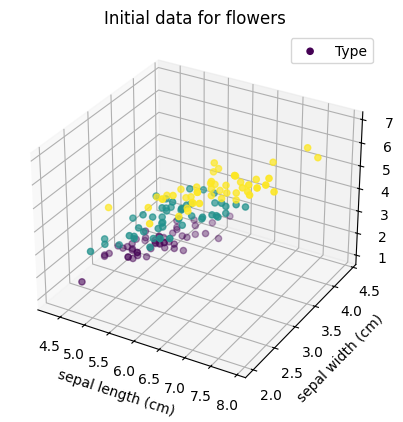

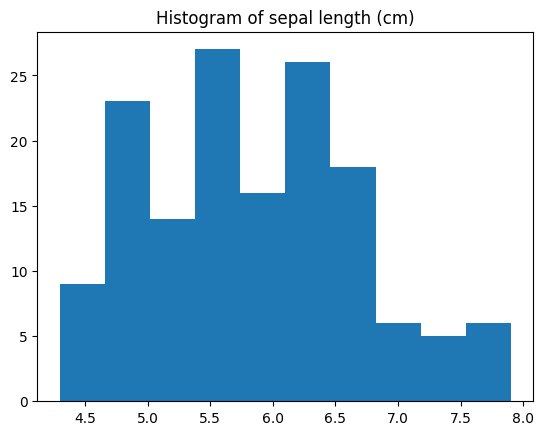

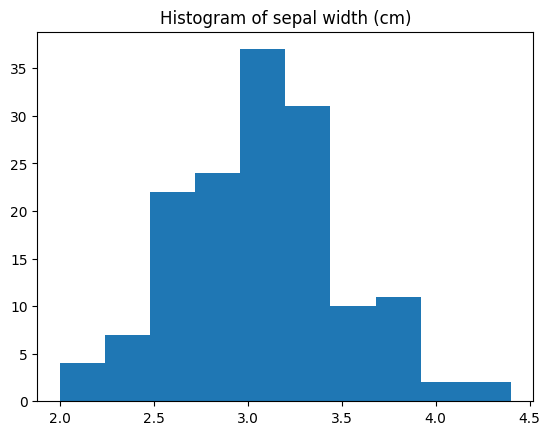

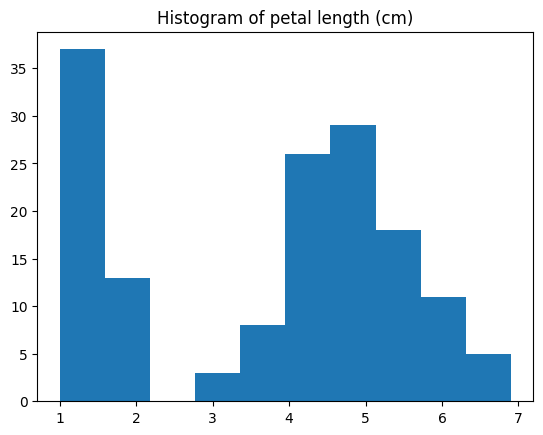

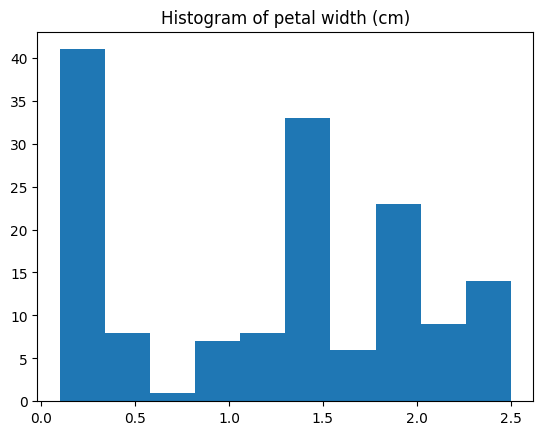

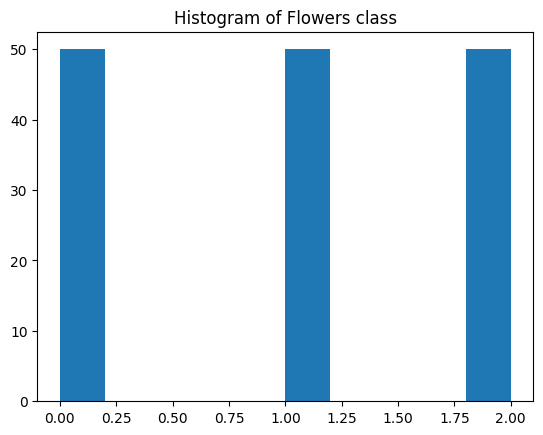

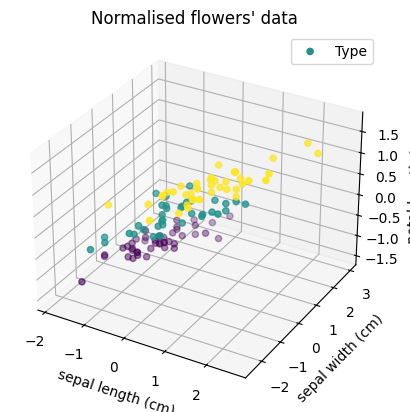

classification model (tool) label 1: y = 0.11910377045311554 + -1.0404407263555284 * x1 + 1.142538982264558 * x2 + -1.792792320906482 * x3 + -1.6492562163047755 * x4
classification model (tool) label 2: y = 1.7882368307749854 + 0.601100213366671 * x1 + -0.35166660329587507 * x2 + -0.32371481793996626 * x3 + -0.8107541796796113 * x4
classification model (tool) label 3: y = -1.9073406012281005 + 0.4393405129888578 * x1 + -0.7908723789686829 * x2 + 2.1165071388464485 * x3 + 2.4600103959843866 * x4
Accuracy score: 0.9333333333333333


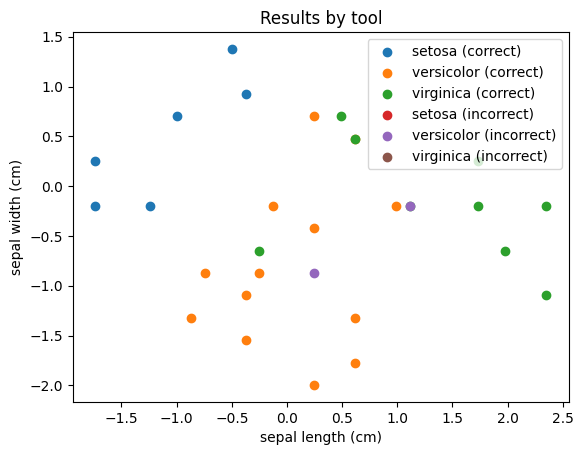

classification error  by tool : 0.06666666666666667
classification model label 1: y = -0.48129128918231373 + -0.9442224008426223 * feat1 + 1.334775675828464 * feat2 + -0.8780878052941318 * feat3 + -1.03966388892894 * feat4
classification model label 2: y = -0.8553811826518546 + -0.09973961180472689 * feat1 + -0.6502616513542508 * feat2 + 0.3760088920789551 * feat3 + -0.07194802468078207 * feat4
classification model label 3: y = -0.8430946371024494 + 0.8300256526107972 * feat1 + 0.1892464112975803 * feat2 + 0.7603107095239892 * feat3 + 0.9490118129584152 * feat4
Accuracy score: 0.7666666666666667


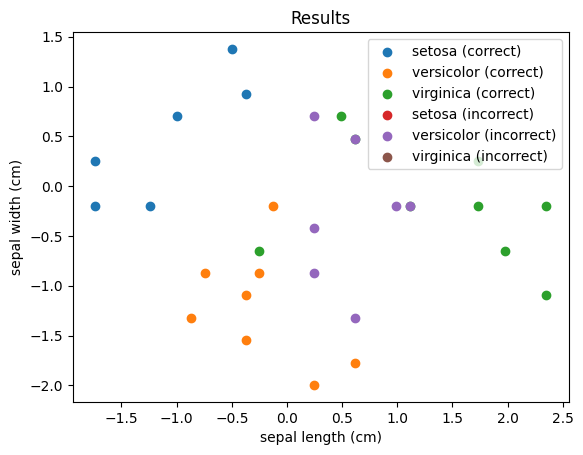

classification error   : 0.23333333333333334

Floarea prezisa:  setosa

Cross validation:

classification model label 1: y = -0.5897710151795357 + -0.8727122993429809 * feat1 + 1.086543639602543 * feat2 + -1.0387648789193498 * feat3 + -0.6024914899952489 * feat4
classification model label 2: y = -0.5991401999511039 + -0.16261694181999617 * feat1 + -0.6999928065248121 * feat2 + 0.11678859430345913 * feat3 + 0.06602675177250364 * feat4
classification model label 3: y = -0.6697330804135819 + 0.762407866755895 * feat1 + 0.4918500866561753 * feat2 + 0.9509903523406013 * feat3 + 1.2238155571032372 * feat4
Accuracy score: 0.8666666666666667
classification error   : 0.13333333333333333


classification model label 1: y = -0.3289383160382853 + -0.6443332011338792 * feat1 + 1.3369279051041747 * feat2 + -0.9266929164021748 * feat3 + -1.0082860260335251 * feat4
classification model label 2: y = -0.9106694599584737 + -0.38812860252343906 * feat1 + -0.5597133493783107 * feat2 + 0.5006714771605993 * 

In [57]:
# load data
inputs, outputs, outputNames, feature1, feature2, feature3, feature4, featureNames = loadData()
# plot initial data
plotData(inputs, outputs, outputNames, featureNames, "Initial data for flowers")

# plot histohram for each feature
plotHistogram(feature1, featureNames[0])
plotHistogram(feature2, featureNames[1])
plotHistogram(feature3, featureNames[2])
plotHistogram(feature4, featureNames[3])
plotHistogram(outputs, 'Flowers class')

# split data into training and testing sets
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)
# normalize data
trainInputs, testInputs = normalisation(trainInputs, testInputs)
# plot normalized data
plotData(trainInputs, trainOutputs, outputNames, featureNames, "Normalised flowers' data")

# learn and evaluate model by tool
computedTestOutputs = learnModelTool(trainInputs, trainOutputs, testInputs, testOutputs)
plotPredictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames[:2], "Results by tool")
calculatePerformance(computedTestOutputs, testOutputs, "by tool")

# prediction new flower
dimensiuni_floare = [[5.35, 3.58, 1.25, 0.4]]
dim, dimensiuni = normalisation(dimensiuni_floare, dimensiuni_floare)

# learn and evaluate model
computedTestOutputs, flower = learnModel(trainInputs, trainOutputs, testInputs, testOutputs, dimensiuni)
plotPredictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames[:2], "Results")
calculatePerformance(computedTestOutputs, testOutputs, "")

# flower predition
print("\nFloarea prezisa: ", outputNames[flower[0]])

print("\nCross validation:\n")
data = crossValidation(inputs, outputs)
for index in range(4):
    testInputs = data[index]['inputs']
    testOutputs = data[index]['outputs']
    trainInputs = []
    trainOutputs = []
    for dictionary in data[:index] + data[index + 1:]:
        trainInputs += dictionary['inputs']
        trainOutputs += dictionary['outputs']
    trainInputs, testInputs = normalisation(trainInputs, testInputs)
    computedTestOutputs, flower = learnModel(trainInputs, trainOutputs, testInputs, testOutputs, dimensiuni)
    calculatePerformance(computedTestOutputs, testOutputs, "")
    print("\n")